In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.5,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_05_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 12:39 - loss: 0.0443 - STD: 1.1441e-04 - MAE: 0.1961

 15/735 [..............................] - ETA: 2s - loss: 0.0179 - STD: 1.3625e-04 - MAE: 0.1041   

 30/735 [>.............................] - ETA: 2s - loss: 0.0142 - STD: 1.4678e-04 - MAE: 0.0918

 45/735 [>.............................] - ETA: 2s - loss: 0.0126 - STD: 1.8542e-04 - MAE: 0.0866

 54/735 [=>............................] - ETA: 7s - loss: 0.0120 - STD: 2.1856e-04 - MAE: 0.0846

 66/735 [=>............................] - ETA: 6s - loss: 0.0115 - STD: 2.7622e-04 - MAE: 0.0828

 77/735 [==>...........................] - ETA: 6s - loss: 0.0112 - STD: 3.5334e-04 - MAE: 0.0819

 88/735 [==>...........................] - ETA: 5s - loss: 0.0110 - STD: 4.7013e-04 - MAE: 0.0812

 99/735 [===>..........................] - ETA: 5s - loss: 0.0107 - STD: 6.5800e-04 - MAE: 0.0804

111/735 [===>..........................] - ETA: 4s - loss: 0.0105 - STD: 0.0010 - MAE: 0.0797    

125/735 [====>.........................] - ETA: 4s - loss: 0.0103 - STD: 0.0020 - MAE: 0.0789

141/735 [====>.........................] - ETA: 4s - loss: 0.0100 - STD: 0.0047 - MAE: 0.0778

156/735 [=====>........................] - ETA: 3s - loss: 0.0097 - STD: 0.0083 - MAE: 0.0767

171/735 [=====>........................] - ETA: 3s - loss: 0.0094 - STD: 0.0115 - MAE: 0.0755

184/735 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 0.0145 - MAE: 0.0745

197/735 [=======>......................] - ETA: 3s - loss: 0.0090 - STD: 0.0170 - MAE: 0.0736

213/735 [=======>......................] - ETA: 2s - loss: 0.0088 - STD: 0.0198 - MAE: 0.0724

228/735 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.0223 - MAE: 0.0713

242/735 [========>.....................] - ETA: 2s - loss: 0.0083 - STD: 0.0246 - MAE: 0.0704

258/735 [=========>....................] - ETA: 2s - loss: 0.0082 - STD: 0.0267 - MAE: 0.0695

275/735 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.0288 - MAE: 0.0687

290/735 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.0306 - MAE: 0.0679

305/735 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0321 - MAE: 0.0672

319/735 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.0336 - MAE: 0.0666

335/735 [============>.................] - ETA: 1s - loss: 0.0074 - STD: 0.0350 - MAE: 0.0660

351/735 [=============>................] - ETA: 1s - loss: 0.0073 - STD: 0.0363 - MAE: 0.0654

367/735 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0376 - MAE: 0.0649

382/735 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.0387 - MAE: 0.0645

397/735 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0397 - MAE: 0.0641

412/735 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0406 - MAE: 0.0637

427/735 [================>.............] - ETA: 1s - loss: 0.0069 - STD: 0.0414 - MAE: 0.0633

441/735 [=================>............] - ETA: 1s - loss: 0.0068 - STD: 0.0422 - MAE: 0.0630

457/735 [=================>............] - ETA: 1s - loss: 0.0068 - STD: 0.0430 - MAE: 0.0626

471/735 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0437 - MAE: 0.0623

483/735 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0443 - MAE: 0.0620

497/735 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0449 - MAE: 0.0617

512/735 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0455 - MAE: 0.0614

524/735 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0460 - MAE: 0.0612

539/735 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0465 - MAE: 0.0610

553/735 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0470 - MAE: 0.0608

566/735 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0474 - MAE: 0.0605

578/735 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0478 - MAE: 0.0604

593/735 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0484 - MAE: 0.0601

606/735 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0488 - MAE: 0.0600

620/735 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0492 - MAE: 0.0598

635/735 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0496 - MAE: 0.0596

648/735 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0500 - MAE: 0.0594

661/735 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0503 - MAE: 0.0592

677/735 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0507 - MAE: 0.0590

692/735 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0511 - MAE: 0.0588

705/735 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0513 - MAE: 0.0587

722/735 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0518 - MAE: 0.0585

735/735 [==============================] - 5s 5ms/step - loss: 0.0059 - STD: 0.0520 - MAE: 0.0584 - val_loss: 0.0037 - val_STD: 0.0477 - val_MAE: 0.0469


Epoch 2/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0494

 17/735 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0509 

 33/735 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0507

 49/735 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0670 - MAE: 0.0506

 65/735 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

 80/735 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

 96/735 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

110/735 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

125/735 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0506

139/735 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

154/735 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

170/735 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

186/735 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

202/735 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

217/735 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

232/735 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0504

248/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0504

264/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

279/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

295/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

311/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

328/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

344/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0500

360/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

376/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

390/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

405/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

421/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

437/735 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0500

452/735 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

465/735 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0499

481/735 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

497/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

514/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

530/735 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

544/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

560/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

576/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

592/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

608/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

625/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

641/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

657/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

673/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

688/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

703/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

717/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

732/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

735/735 [==============================] - 3s 4ms/step - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494 - val_loss: 0.0040 - val_STD: 0.0467 - val_MAE: 0.0451


Epoch 3/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0045 - STD: 0.0621 - MAE: 0.0480

 13/735 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494 

 25/735 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0489

 39/735 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

 53/735 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

 67/735 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

 81/735 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

 95/735 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

111/735 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

127/735 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

143/735 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

160/735 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0480

177/735 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0479

192/735 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

205/735 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

218/735 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

229/735 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

241/735 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

253/735 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

267/735 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

279/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

291/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

303/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

316/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

329/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

343/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

358/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

373/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

386/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

398/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

410/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

425/735 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

442/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

458/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

474/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

489/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

504/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

519/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

532/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

545/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

559/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

575/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

590/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

605/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

620/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

635/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

647/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

659/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

673/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

688/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

704/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

719/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

735/735 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

735/735 [==============================] - 3s 4ms/step - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467 - val_loss: 0.0034 - val_STD: 0.0575 - val_MAE: 0.0457


Epoch 4/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0517

 16/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0451 

 31/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

 47/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

 63/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

 79/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

 95/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

111/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

127/735 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

143/735 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

159/735 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

173/735 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

185/735 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

196/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

207/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

220/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

236/735 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

251/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

265/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

281/735 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

295/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

311/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

328/735 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

345/735 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

361/735 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

377/735 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

393/735 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

409/735 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

425/735 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

437/735 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

448/735 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

463/735 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

479/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

496/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

514/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

530/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

547/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

564/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

580/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

597/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

613/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

629/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

645/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

661/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

678/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

695/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

712/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

729/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

735/735 [==============================] - 3s 4ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447 - val_loss: 0.0034 - val_STD: 0.0639 - val_MAE: 0.0446


Epoch 5/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0500

 15/735 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0455 

 27/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0451

 39/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0446

 51/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0443

 63/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0441

 75/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0441

 88/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0441

100/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0442

112/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

124/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

136/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

150/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

164/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

178/735 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

193/735 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

208/735 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

224/735 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

238/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

253/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

269/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

285/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

300/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

315/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

330/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

346/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

362/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

377/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

393/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

408/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

423/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

438/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

453/735 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

468/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

479/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

491/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

504/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0431

516/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0431

528/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

541/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

556/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

572/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

585/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

597/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

609/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

623/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

635/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

648/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

660/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

672/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

684/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

697/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

709/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

721/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430 - val_loss: 0.0032 - val_STD: 0.0596 - val_MAE: 0.0412


Epoch 6/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0433

 14/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0415 

 30/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

 45/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

 61/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

 76/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

 91/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

108/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

121/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

137/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

152/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

167/735 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

183/735 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

198/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

213/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

228/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

244/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

258/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

273/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

289/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

305/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

318/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

333/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

348/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

364/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

381/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

398/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

415/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

431/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

448/735 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

463/735 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

478/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

493/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

508/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

524/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

541/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

556/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

572/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

588/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

605/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0417

622/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0417

638/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0417

655/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0417

671/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0417

688/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

704/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

719/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417

734/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0613 - val_MAE: 0.0399


Epoch 7/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0413

 15/735 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0407 

 27/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0413

 39/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 52/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

 67/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0408

 78/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

 93/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

105/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

118/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0410

130/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

145/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

160/735 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

174/735 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

187/735 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

199/735 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

212/735 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

228/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

244/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

259/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

275/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

291/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

307/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

322/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

336/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

348/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

359/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

371/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

383/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

396/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

411/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

426/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

443/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

458/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

474/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

489/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

504/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

517/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

532/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

547/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

561/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

577/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

593/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

609/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

625/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

642/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

658/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

673/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

688/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

703/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

716/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

732/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

735/735 [==============================] - 3s 4ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407 - val_loss: 0.0034 - val_STD: 0.0580 - val_MAE: 0.0417


Epoch 8/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0409

 14/735 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0755 - MAE: 0.0406 

 28/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0406

 43/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0407

 58/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0407

 73/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

 87/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

102/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

117/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

131/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

146/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

161/735 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

176/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

191/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

206/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

221/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

236/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

252/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

269/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

285/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

300/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

316/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

332/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

348/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

363/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

376/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

389/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

403/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

420/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

437/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

452/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

464/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

479/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

494/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

508/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

523/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

536/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

547/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

560/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

575/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

590/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

602/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0402

614/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

625/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

640/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0402

654/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0402

666/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

680/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

692/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

707/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

719/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

731/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

735/735 [==============================] - 3s 4ms/step - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401 - val_loss: 0.0029 - val_STD: 0.0648 - val_MAE: 0.0395


Epoch 9/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0023 - STD: 0.0773 - MAE: 0.0367

 15/735 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394 

 30/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

 45/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

 61/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 74/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 90/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

106/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0395

122/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

138/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

150/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

165/735 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

179/735 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

194/735 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

210/735 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

226/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

241/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

257/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

274/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

289/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

305/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

322/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

339/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

355/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

371/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

388/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

404/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

420/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

436/735 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

452/735 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

469/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

485/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

502/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

519/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

535/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

551/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

567/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

584/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

599/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

614/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

629/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

645/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

661/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

678/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

694/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

710/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

727/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

735/735 [==============================] - 3s 4ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393 - val_loss: 0.0031 - val_STD: 0.0696 - val_MAE: 0.0414


Epoch 10/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0031 - STD: 0.0863 - MAE: 0.0430

 16/735 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0402 

 31/735 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

 46/735 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

 57/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

 69/735 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

 81/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 93/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

106/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

119/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

131/735 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

143/735 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

155/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

167/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

179/735 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

191/735 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

203/735 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0393

217/735 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

232/735 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

245/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

258/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

274/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

290/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

306/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

322/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

339/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

355/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

371/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

387/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

403/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

420/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

435/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

452/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

468/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

485/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

501/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

517/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

534/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

551/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

567/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

583/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

599/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

616/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

631/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

647/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

663/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

679/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

695/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

711/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

726/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

735/735 [==============================] - 3s 4ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388 - val_loss: 0.0030 - val_STD: 0.0721 - val_MAE: 0.0406


Epoch 11/10000


  1/735 [..............................] - ETA: 22s - loss: 0.0028 - STD: 0.0881 - MAE: 0.0402

 14/735 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0825 - MAE: 0.0388 

 30/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0820 - MAE: 0.0385

 46/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0384

 60/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0385

 72/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0813 - MAE: 0.0383

 84/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0383

 96/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0383

111/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0382

123/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0382

135/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0382

147/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0382

159/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0381

171/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

185/735 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

198/735 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

211/735 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

227/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

243/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

259/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

275/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

291/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

306/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

322/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

337/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

350/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

364/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

379/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

396/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

413/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

428/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

443/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

458/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

473/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

487/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

502/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

516/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

530/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

543/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

556/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

572/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

588/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

604/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

620/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

636/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

652/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

668/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

683/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

699/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

715/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

731/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384 - val_loss: 0.0029 - val_STD: 0.0641 - val_MAE: 0.0391


Epoch 12/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0024 - STD: 0.0765 - MAE: 0.0358

 17/735 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398 

 33/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

 50/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 66/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

 82/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

 98/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

113/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

128/735 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

141/735 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0380

157/735 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0380

173/735 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0380

187/735 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0380

201/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

215/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0380

229/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

245/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

261/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

277/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

293/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

309/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

326/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

342/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

355/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

371/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

387/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

403/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

420/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

436/735 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

453/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

470/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

486/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

498/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

510/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

525/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

541/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

555/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

570/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

584/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

596/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

611/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

625/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

640/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

653/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

667/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

679/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

694/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

708/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

720/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

731/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

735/735 [==============================] - 3s 4ms/step - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377 - val_loss: 0.0030 - val_STD: 0.0643 - val_MAE: 0.0392


Epoch 13/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0792 - MAE: 0.0349

 14/735 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0377 

 28/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

 42/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0372

 55/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0373

 67/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

 78/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

 89/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

102/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

114/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

127/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

140/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

152/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

164/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0377

178/735 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0376

191/735 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

203/735 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0375

216/735 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0375

229/735 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

243/735 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

258/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

273/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

290/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0373

304/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0373

316/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0373

329/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

342/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

354/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

367/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

382/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0372

397/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

412/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

427/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

441/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

452/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

465/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

478/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

491/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

507/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

523/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

539/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

554/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

569/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

587/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

602/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

618/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

635/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

650/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

663/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

675/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

687/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

698/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

710/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

723/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

735/735 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371 - val_loss: 0.0030 - val_STD: 0.0709 - val_MAE: 0.0403


Epoch 14/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0027 - STD: 0.0859 - MAE: 0.0386

 16/735 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0831 - MAE: 0.0371 

 32/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0822 - MAE: 0.0368

 47/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

 63/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

 78/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

 93/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

108/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

123/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

138/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0366

152/735 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

165/735 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0370

179/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

195/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

209/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0371

224/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

241/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

258/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

274/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

290/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

306/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

321/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

336/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

352/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

368/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

384/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

400/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

416/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

430/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

444/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

460/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

476/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

492/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

508/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

524/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

539/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

555/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

572/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

589/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

605/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

621/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

637/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

653/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

669/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

684/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0366

700/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0366

716/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

732/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

735/735 [==============================] - 3s 4ms/step - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365 - val_loss: 0.0029 - val_STD: 0.0685 - val_MAE: 0.0389


Epoch 15/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0021 - STD: 0.0807 - MAE: 0.0341

 16/735 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0815 - MAE: 0.0352 

 30/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0831 - MAE: 0.0360

 43/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0359

 57/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0359

 72/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

 88/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

104/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

120/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

134/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

149/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

166/735 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

181/735 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0364

196/735 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0364

211/735 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

227/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

243/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0364

259/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0364

275/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

291/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

307/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

320/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

334/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

350/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

366/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

377/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

389/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

402/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

414/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

430/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

447/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

462/735 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

477/735 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

493/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

507/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

522/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

537/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

552/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

567/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

582/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

597/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

612/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

628/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

644/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

660/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

677/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

694/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

710/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

726/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

735/735 [==============================] - 3s 4ms/step - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362 - val_loss: 0.0033 - val_STD: 0.0705 - val_MAE: 0.0429


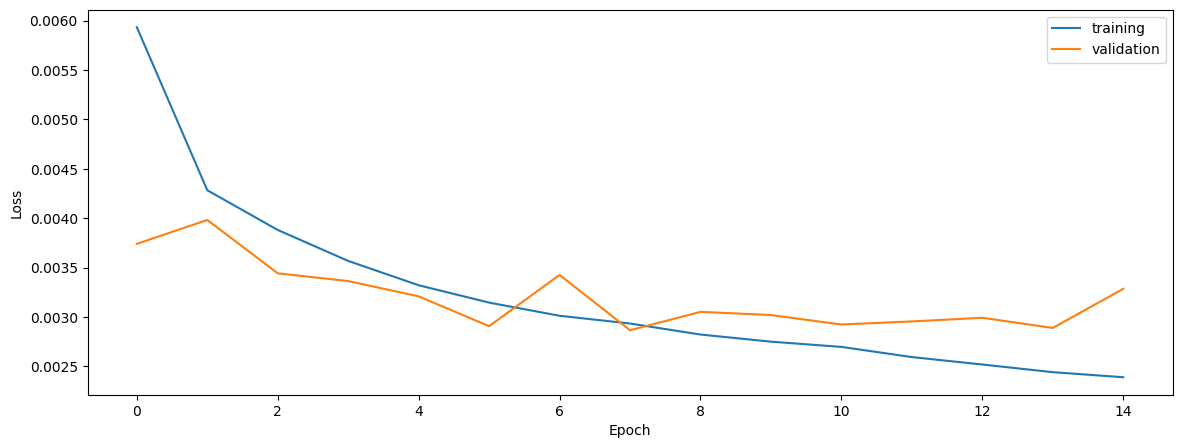

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8382895019866722
0.8174857256588026
0.8169535458937025


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8382895019866722
0.8174857256588026
0.8169535458937025


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8374586927029497
0.8179937661538125
0.816348883692862


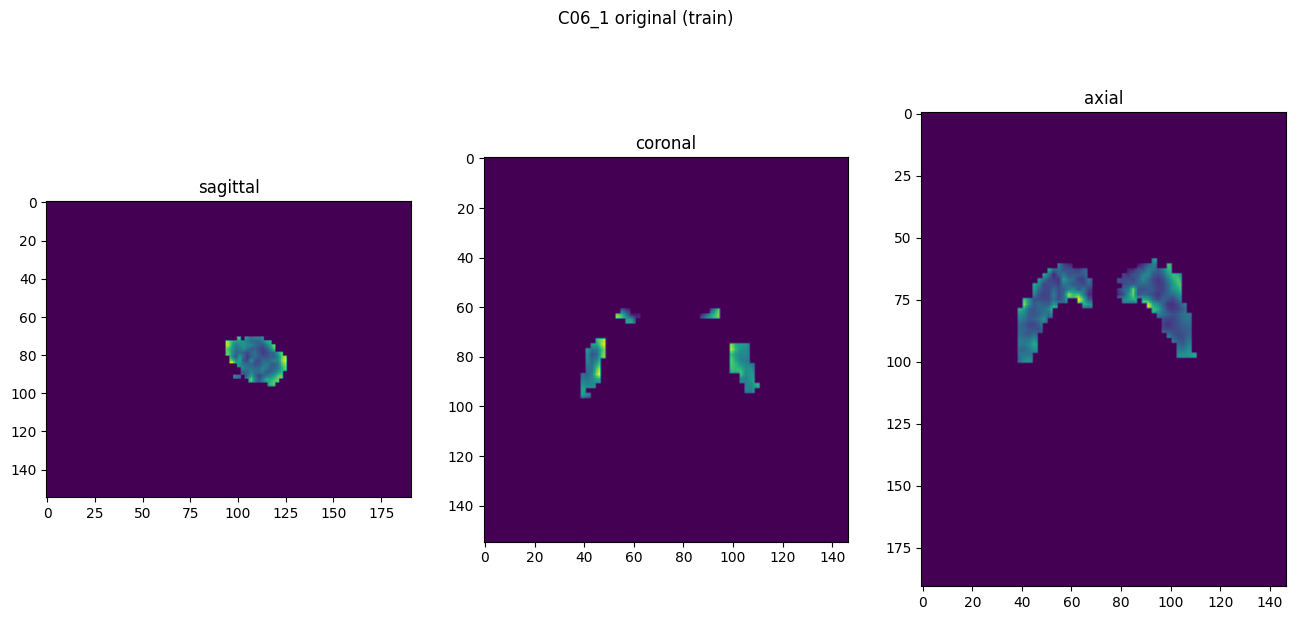

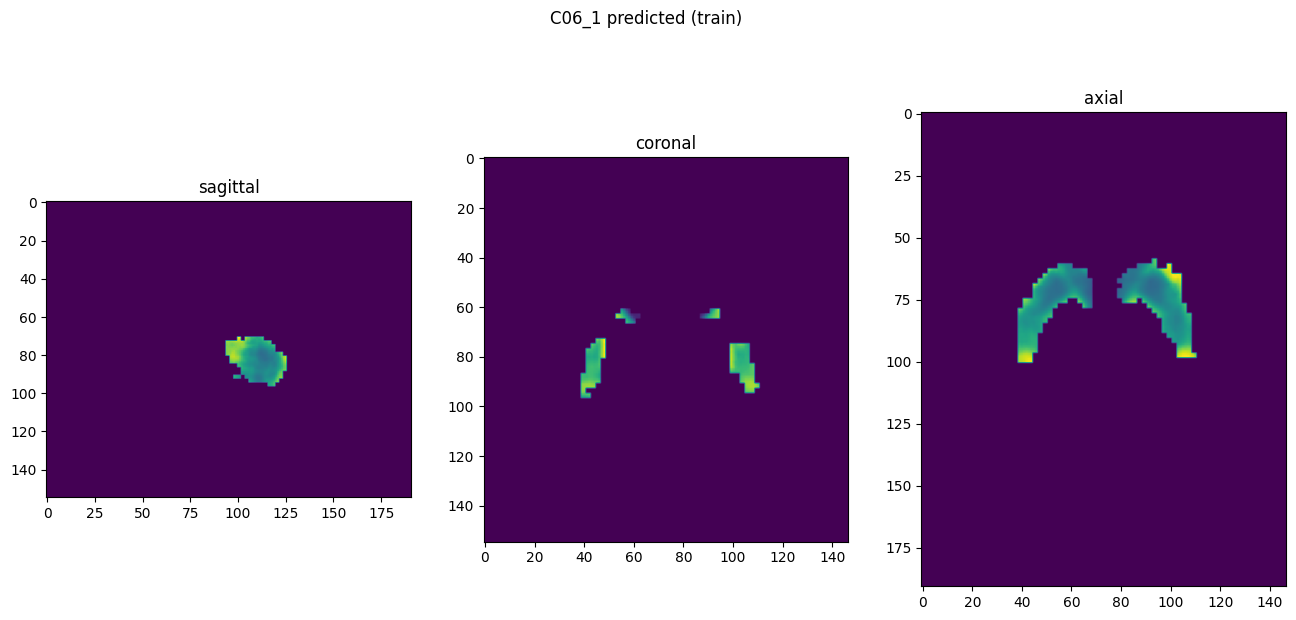

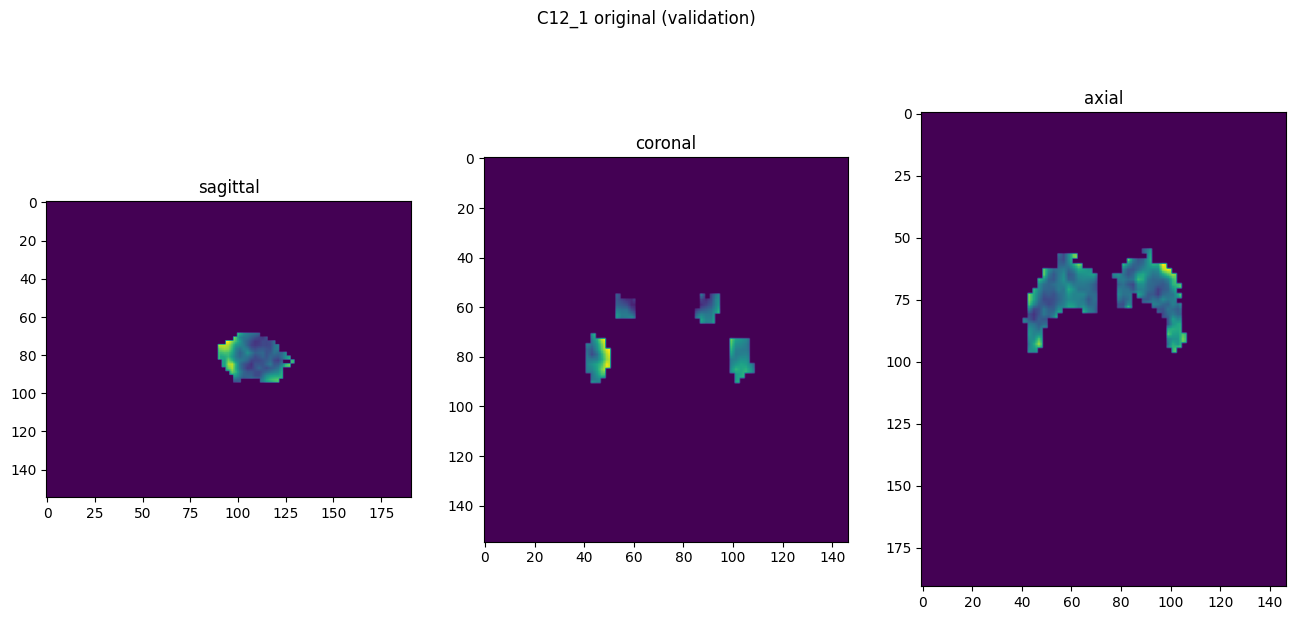

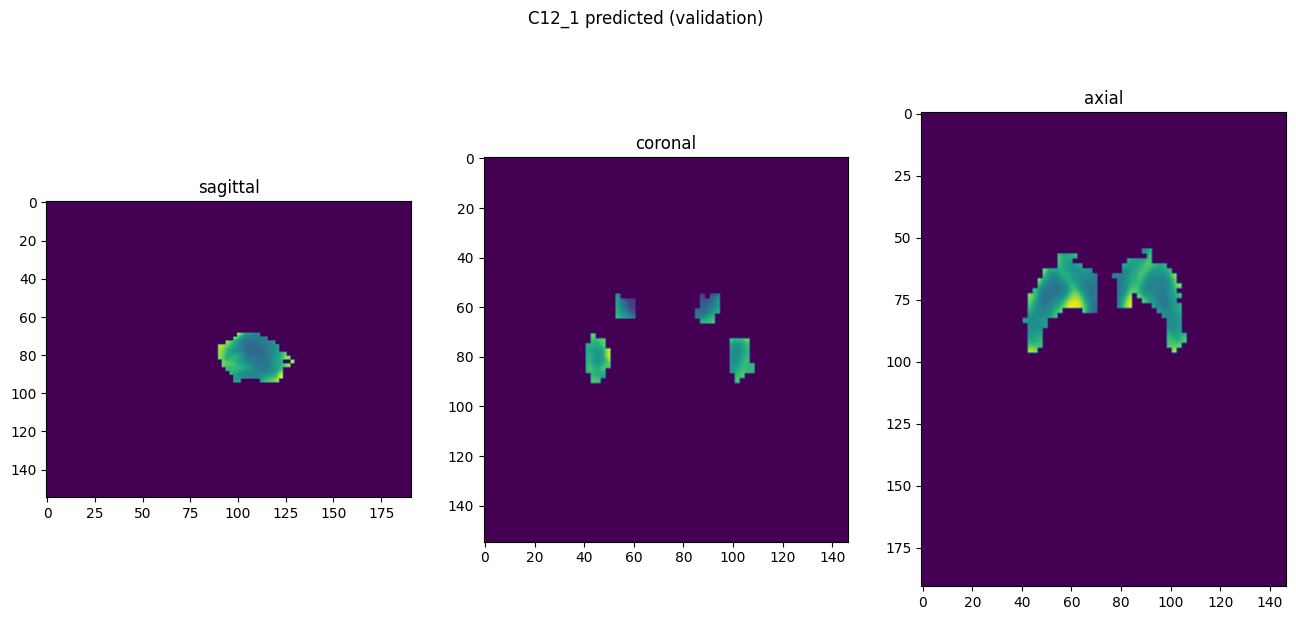

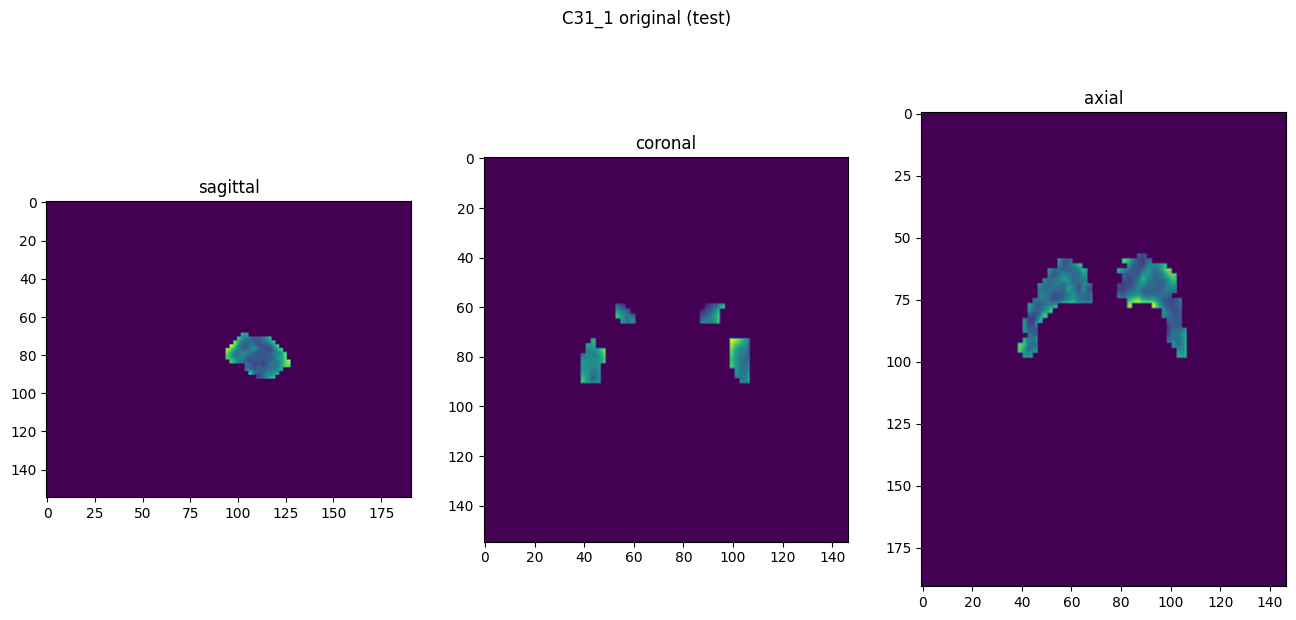

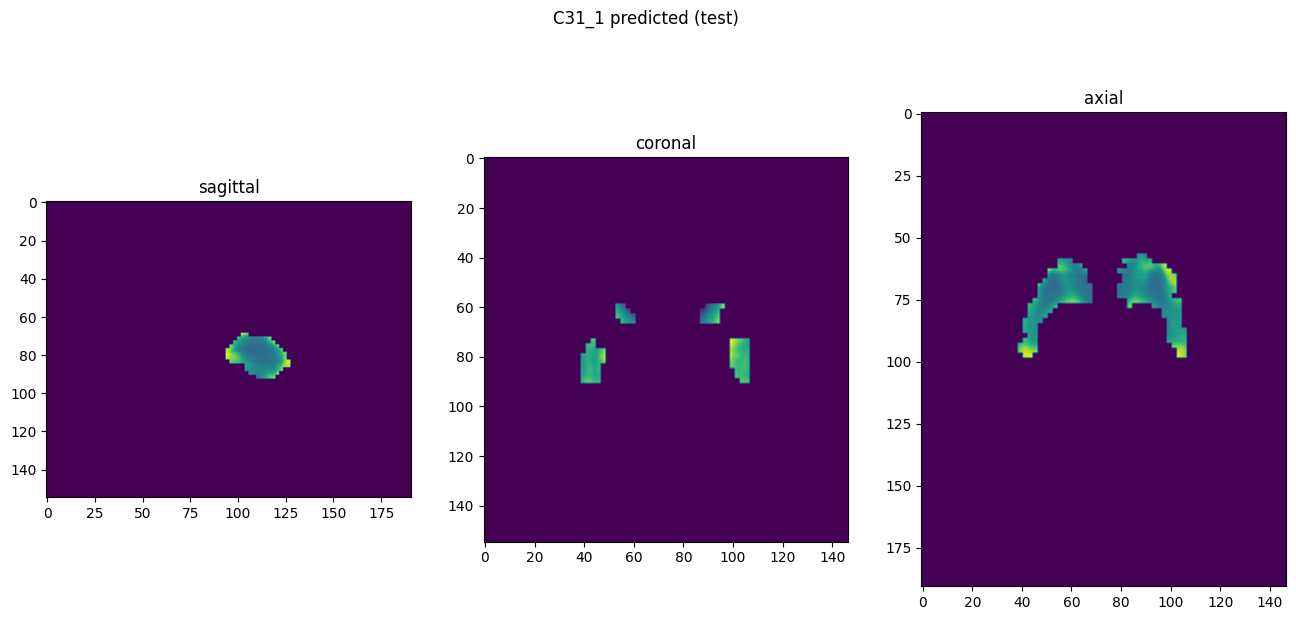

In [10]:
showResults(model, gen, threshold=None, background=False)